In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
)
from torch import nn
from torch.utils.data import DataLoader, Dataset

# 모델 정의 (학습 시 사용한 그대로)
class LIN28ACNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(7, 128, kernel_size=8)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=6)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(256, 128)
        self.out = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return torch.sigmoid(self.out(x)).squeeze(-1)

# 데이터 로드
X = np.load("../data/features/X_all.npy")
y = np.load("../data/features/y_all.npy")

# Test Set 분할 (train/val/test 동일 기준으로)
from sklearn.model_selection import train_test_split
_, X_temp, _, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# DataLoader 정의
class RNADataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

test_dl = DataLoader(RNADataset(X_test, y_test), batch_size=64)

# 모델 로딩
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LIN28ACNN().to(device)
model.load_state_dict(torch.load("../models/best_model.pt"))
model.eval()

# 예측 수집
all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(yb.numpy())

# numpy로 변환
y_true = np.array(all_true)
y_score = np.array(all_preds)
y_pred = (y_score >= 0.5).astype(int)  # threshold 0.5

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# PR Curve
precision, recall, _ = precision_recall_curve(y_true, y_score)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

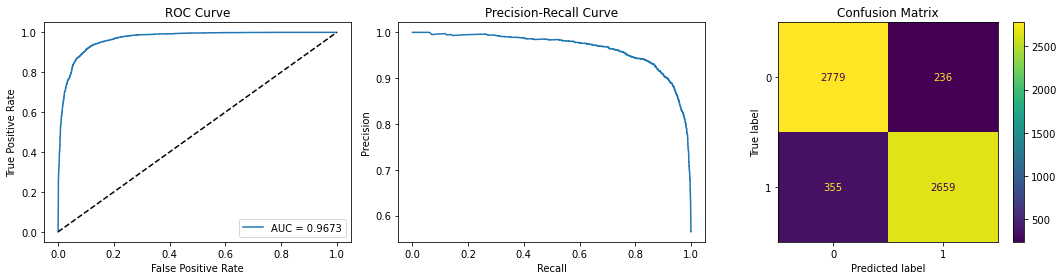

In [2]:

# 📈 시각화
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1,3,2)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

plt.subplot(1,3,3)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()

In [4]:
import json
from sklearn.metrics import precision_score, recall_score, f1_score
import os
# test 성능 계산
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 저장
test_metrics = {
    "auroc": float(roc_auc),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1)
}

os.makedirs("../results/metrics", exist_ok=True)
with open("../results/metrics/final_test_metrics.json", "w") as f:
    json.dump(test_metrics, f, indent=4)

print("✅ 저장 완료: final_test_metrics.json")

✅ 저장 완료: final_test_metrics.json


## 🧪 Step 5: 모델 평가 (ROC / PR Curve, Confusion Matrix)

이 단계에서는 Test Set을 대상으로 모델의 실제 성능을 평가합니다.

### ✅ 평가 항목
- ROC Curve + AUC
- Precision-Recall Curve
- Confusion Matrix (threshold = 0.5 기준)

이 시각화를 통해 모델의 판별력과 오분류 양상을 종합적으로 확인할 수 있습니다.